In [1]:
import pandas as pd
import numpy as np
import ta
from ta.momentum import rsi 
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.style

plt.style.use('ggplot')

In [2]:
class TesterBase():
  def __init__(self, simbolo, data_origen, inicio, final, monto, usar_spread=True):
    self.simbolo = simbolo
    self.data_origen = data_origen 
    self.inicio = inicio
    self.final = final
    self.balance_inicial = monto
    self.balance_actual = monto
    self.unidades_en_activos = 0 
    self.trades = 0      
    self.posicion = 0
    self.usar_spread = usar_spread
    self.obtener_data()

  def obtener_data(self):
    if self.data_origen == "local":
      ruta_data = "<<<<<<<<<< RUTA A DATA LOCAL EN EL DRIVE >>>>>>>>>>>>>>"
      raw = pd.read_csv(ruta_data, parse_dates=['Gmt time'], index_col="Gmt time").dropna() 
      raw = raw.loc[self.inicio : self.final]
      self.data = raw

    if self.data_origen == "yahoo":
      raw = yf.download(self.simbolo, interval="1d", start=self.inicio, end=self.final)
      raw = raw.rename(columns = {'Close':'Precio'})

      if 'Spread' in raw.columns or 'spread' in raw.columns:
        self.data = raw
      else:
        raw['Spread'] = 0
        self.data = raw

  def obtener_valores_por_index(self, vela):
    date = str(self.data.index[vela].date())
    precio = round(self.data['Precio'].iloc[vela], 5)
    spread = round(self.data['Spread'].iloc[vela], 5)
    return date, precio, spread

  def imprimir_balance_actual(self, vela):
    date, precio, spread = self.obtener_valores_por_index(vela)
    print("{} | Balance Inicial: {}".format(self.inicio, round(self.balance_inicial, 2)))
    print("{} | Balance Actual: {}".format(date, round(self.balance_actual, 2)))

  def comprar_instrumento(self, vela, unidades_en_activos=None, monto=None):
    date, precio, spread = self.obtener_valores_por_index(vela)
    if self.usar_spread:
      precio += spread/2 
    if monto is not None: 
      unidades_en_activos = int(monto / precio) 
    self.balance_actual -= unidades_en_activos * precio 
    self.unidades_en_activos += unidades_en_activos
    self.trades += 1
    print("{} | Comprando: {}, {}, por: {}".format(date, unidades_en_activos, self.simbolo, precio))

  def vender_instrumento(self, vela, unidades_en_activos=None, monto=None):
    date, precio, spread = self.obtener_valores_por_index(vela)
    if self.usar_spread:
      precio -= spread/2 
    if monto is not None: 
      unidades_en_activos = int(monto / precio)
    self.balance_actual += unidades_en_activos * precio 
    self.unidades_en_activos -= unidades_en_activos
    self.trades += 1
    print("{} | Vendiendo: {}, {}, por: {}".format(date, unidades_en_activos, self.simbolo, precio))

  def imprimir_valor_de_posicion_actual(self, vela):
    date, precio, spread = self.obtener_valores_por_index(vela)
    cpv = self.unidades_en_activos * precio
    print("{} | Valor de la posicion actual: {}".format(date, cpv))

  def imprimir_valor_neto_del_activo(self, vela):
    date, precio, spread = self.obtener_valores_por_index(vela)
    net_asset_value = self.balance_actual + (self.unidades_en_activos * precio)
    print("{} | Valor Neto Actual: {}".format(date, net_asset_value))

  def cerrar_posicion(self, vela):
    date, precio, spread = self.obtener_valores_por_index(vela)
    print(100 * "-")
    print("{} | \-\-\-\-\-\ FINAL DEL BACKTEST /-/-/-/-/-/". format(date))
    self.balance_actual += self.unidades_en_activos * precio 
    self.balance_actual -= (abs(self.unidades_en_activos) * (spread / 2) * self.usar_spread)
    print("{} | Cerrando posicion de: {} | por: {}".format(date, self.unidades_en_activos, precio))
    self.unidades_en_activos = 0 
    self.trades += 1
    perf = (self.balance_actual - self.balance_inicial) / self.balance_inicial * 100 
    self.imprimir_balance_actual(vela)
    print("{} | Rendimiento Neto (%): {}".format(date, round(perf, 2)))
    print("{} | Numero de Trades: {}".format(date, self.trades))
    print(100 * "-") 

  # Performance de la Estrategia
  def Medidores_de_Riesgo(self):
    df = self.data.copy().dropna()
    riskfree_rate = 0.022

    # Prepara los datos que son necesarios para el uso del metodo 'Medidores_de_Riesgo'
    df['instrumento_retornos']   = df['Precio'].pct_change()
    df['estrategia_retornos'] = df['Posicion'].shift(1) * df['instrumento_retornos']
    # df.dropna(inplace=True)
    df['instrumento_retornos_acum'] = df['instrumento_retornos'].cumsum().apply(np.exp)
    df['estrategia_retornos_acum'] = df['estrategia_retornos'].cumsum().apply(np.exp)

    # Performance Absoluto ----------------------------------------------------/
    perf = df['estrategia_retornos_acum'][-1] 
    # % Superado --------------------------------------------------------------/
    pct_superado = perf - df['instrumento_retornos_acum'][-1] 
    # CAGR --------------------------------------------------------------------/
    numero_de_anios = len(df)/252 
    CAGR = (df['estrategia_retornos_acum'][-1])**(1/numero_de_anios) -1 
    # Volatilidad Anual -------------------------------------------------------/
    vol = df['instrumento_retornos'].std()* np.sqrt(252) 
    # Sharpe Ratio ------------------------------------------------------------/
    sharpe_ratio = (CAGR - riskfree_rate) / vol
    # Sortino Ratio -----------------------------------------------------------/
    neg_vol = df[df['instrumento_retornos'] < 0]['instrumento_retornos'].std()* np.sqrt(252) 
    sortino_ratio = (CAGR - riskfree_rate) / neg_vol
    # MDD ---------------------------------------------------------------------/
    df['max_ret_acum'] = df['estrategia_retornos_acum'].cummax()
    df['drawdown']     = df['max_ret_acum'] - df['estrategia_retornos_acum']
    df['drawdown_pct'] = df['drawdown'] / df['max_ret_acum']
    mdd                = df['drawdown_pct'].max()
    # Calmar Ratio ------------------------------------------------------------/
    calmar = CAGR / mdd
    # Imprime los valores con su respectivo texto -----------------------------/
    print("RENDIMIENTO DE LA ESTRATEGIA")
    print("-" * 100)

    print("% Rendimiento Estrategia: " + str(round((perf*100), 2)) + "%")
    print("% Superado al Benchmark:  " + str(round((pct_superado*100), 2)) + "%")
    print("% Rendimiento Benchmark:  " + str(round((df['instrumento_retornos_acum'][-1]*100), 2)) + "%")
    print("CAGR (Rendimiento Anual)  " + str(round((CAGR*100), 2)) + "%")
    print("Volatilidad Anual:        " + str(round((vol*100), 2)) + "%")
    print("Maximum Drawdown:         " + str(round((mdd*100), 2)) + "%")
    print("Sharpe R.                 " + str(round(sharpe_ratio, 2)))
    print("Sortino R.                " + str(round(sortino_ratio, 2)))
    print("Calmar R.                 " + str(round(calmar, 2)))
    print("-" * 100)

  def plotear_data(self, cols=None):
    if cols is None:
      cols = "Price"
    self.data[cols].plot(figsize=(12,6), title=self.simbolo)


## BacktesterIterativo *(child)*

In [87]:
class BacktesterIterativo(TesterBase):
  
  # Metodo ayuda Comprar
  def ir_long(self, vela, unidades_en_activos=None, monto=None):
    
    # Comprueba si hay una posición Short activa
    if self.posicion == -1: 

      # Si existe posición Short, compramos el mismo monto de unidades que estamos en Short, 
      # esto nos coloca en una posición neutral.
      self.comprar_instrumento(vela, unidades_en_activos= -self.unidades_en_activos) 
    if unidades_en_activos:
      self.comprar_instrumento(vela, unidades_en_activos= unidades_en_activos)
    elif monto:
      if monto == 'todo':
        monto = self.balance_actual
      self.comprar_instrumento(vela, monto=monto) # Ir Long

  # Metodo ayuda Vender
  def ir_short(self, vela, unidades_en_activos=None, monto=None):
    
    # Comprueba si hay una posición Long activa
    if self.posicion == 1: 
      
      # Si existe posición Long, vendemos el mismo monto de unidades que estamos en Long, 
      # esto nos coloca en una posición neutral.
      self.vender_instrumento(vela, unidades_en_activos= self.unidades_en_activos)
    if unidades_en_activos:
      self.vender_instrumento(vela, unidades_en_activos = unidades_en_activos)
    elif monto:
      if monto == 'todo':
        monto = self.balance_actual
      self.vender_instrumento(vela, monto=monto) # Ir Short

  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  # ESTRATEGIA CRUCE SMA -------------------------------------------------------------------------------------+
  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  def Estrategia_Cruce_SMAs(self, plot_graph=True):

    # Imprime datos de la estrategia
    stm = "TESTANDO LA ESTRATEGIA: Cruce de SMAs | {} | sma_rapida: {} | sma_lenta: {}".format(self.simbolo, 50, 100)
    print("-" * 100)
    print(stm)
    print("-" * 100)

    # Resetea el backtest
    self.posicion = 0 # Posicion inicial neutral
    self.trades   = 0 # No Trades aun
    self.balance_actual = self.balance_inicial # Resetea el capital inicial
    self.obtener_data() # Resetea la data

    # Preparar datos (calcula las SMAs)
    from ta.trend import SMAIndicator

    # Al principio nombramos la nueva columna según el valor que se coloca en los parámetros SMAs
    self.data["SMA_R: "+str(50)] = SMAIndicator(self.data['Precio'], 50, False).sma_indicator() 
    self.data["SMA_L: "+str(100)]  = SMAIndicator(self.data['Precio'], 100, False).sma_indicator() 
    self.data.dropna(inplace=True)

    # Cruce de las SMAs 
    self.data['Posicion'] = 0 # Crea la columna 'Posición' (la usaremos para plotear los resultados)

    for vela in range(len(self.data)-1): # Todas las velas excepto la última vela

      # Senal para ir Long
      if self.data["SMA_R: "+str(50)].iloc[vela] > self.data["SMA_L: "+str(100)].iloc[vela]: 
        if self.posicion in [0, -1]: # Comprueba si la posición es neutra (0) o Short (-1)
          self.ir_long(vela, monto = 'todo') # Ir Long con todo el monto disponible
          self.posicion = 1 # Posicion Long 
          
          # Popula la columna 'posiciones' en cada loop (con señales de compra (1))          
          self.data.at[self.data.index[vela], 'Posicion'] = self.posicion 
      
      # Senal para ir Short
      elif self.data["SMA_R: "+str(50)].iloc[vela] < self.data["SMA_L: "+str(100)].iloc[vela]: 
        if self.posicion in [0, 1]: # Comprueba si la posición es neutra (0) o Long (1)
          self.ir_short(vela, monto = 'todo') # Ir Short con todo el monto disponible
          self.posicion = -1 # Posicion Short 
          
          # Popula la columna 'posiciones' en cada loop (con señales de venta (-1))
          self.data.at[self.data.index[vela], 'Posicion'] = self.posicion 

    if self.trades > 0:
      self.cerrar_posicion(vela+1) # Cierra la posicion en la ultima vela
    else:
      print("NO HAY TRADES EN ESTE PERIODO DE TIEMPO. Prueba con otro período")
      print(100 * "-")

    # Imprime los Medidores de Riesgo en la estrategia
    self.Medidores_de_Riesgo()
    # Plotea el grafico de la estrategia, incluido los marcadores de los trades
    if plot_graph and self.trades > 0:
      fig = plt.figure(figsize=(24,18))
      ax1 = plt.subplot2grid((2,1), (1,0), rowspan=2, colspan=1)
      ax1.plot(self.data['Precio'], label="precio", color='black')
      ax1.plot(self.data["SMA_R: "+str(50)], label = str(50) + " periodos SMA")
      ax1.plot(self.data["SMA_L: "+str(100)], label = str(100) + " periodos SMA")
      # Plotea Trades en Long
      ax1.plot(self.data[self.data['Posicion'] == 1].index, 
              self.data['Precio'][self.data['Posicion'] == 1], '^', markersize = 15, color='green', label='Long')
      # Plotea Trades en Short
      ax1.plot(self.data[self.data['Posicion'] == -1].index, 
              self.data['Precio'][self.data['Posicion'] == -1], 'v', markersize = 15, color='red', label='Short')

      plt.title(self.simbolo +"\n Estrategia Cruce SMAs "+str(50)+ " - " +str(100), fontsize = 20)
      plt.legend(fontsize = 15)
      plt.show()

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  # ESTRATEGIA MEAN REVERSION ---------------------------------------------------------------+
  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

  def Estrategia_Mean_Reversion(self, sma_lenta =30, plot_graph=True):

    # Imprime datos de la estrategia
    stm = "TESTANDO LA ESTRATEGIA: Mean Reversion | {} | sma_lenta: {}".format(self.simbolo, sma_lenta)
    print("-" * 100)
    print(stm)
    print("-" * 100)

    # Resetea el backtest
    self.posicion = 0 # Posicion inicial neutral
    self.trades   = 0 # No Trades aun
    self.balance_actual = self.balance_inicial # Resetea el capital inicial
    self.obtener_data() # Resetea la data

    # Preparar datos (calcula las SMAs)
    from ta.trend import SMAIndicator

    # Al principio nombramos la nueva columna según el valor que se coloca en los parámetros SMAs
    self.data["SMA_L: "+str(sma_lenta)]  = SMAIndicator(self.data['Precio'], sma_lenta, False).sma_indicator() 

    self.data.dropna(inplace=True)

    # Cruce de las SMAs 
    self.data['Posicion'] = 0 # Crea la columna 'Posición' (la usaremos para plotear los resultados)
    self.data['Ratio'] = self.data['Precio']/ self.data["SMA_L: "+str(sma_lenta)]
    percentiles = [15,20,50,80,85]
    ratios = self.data['Ratio'].dropna()
    percentiles_values = np.percentile(ratios,percentiles)
    

    for vela in range(len(self.data)-1): # Todas las velas excepto la última vela
      # Senal para ir Long
      if self.data['Ratio'].iloc[vela] < percentiles_values[-1]: 
        if self.posicion in [0, -1]: # Comprueba si la posición es neutra (0) o Short (-1)
          self.ir_long(vela, monto = 'todo') # Ir Long con todo el monto disponible
          self.posicion = 1 # Posicion Long 
          
          # Popula la columna 'posiciones' en cada loop (con señales de compra (1))          
          self.data.at[self.data.index[vela], 'Posicion'] = self.posicion 
      
      # Senal para ir Short
      elif self.data['Ratio'].iloc[vela] > percentiles_values[-1]: 
        if self.posicion in [0, 1]: # Comprueba si la posición es neutra (0) o Long (1)
          self.ir_short(vela, monto = 'todo') # Ir Short con todo el monto disponible
          self.posicion = -1 # Posicion Short 
          
          # Popula la columna 'posiciones' en cada loop (con señales de venta (-1))
          self.data.at[self.data.index[vela], 'Posicion'] = self.posicion 

    if self.trades > 0:
      self.cerrar_posicion(vela+1) # Cierra la posicion en la ultima vela
    else:
      print("NO HAY TRADES EN ESTE PERIODO DE TIEMPO. Prueba con otro período")
      print(100 * "-")

    # Imprime los Medidores de Riesgo en la estrategia
    self.Medidores_de_Riesgo()

    # Plotea el grafico de la estrategia, incluido los marcadores de los trades
    if plot_graph and self.trades > 0:
      fig = plt.figure(figsize=(24,18))
      ax1 = plt.subplot2grid((2,1), (1,0), rowspan=2, colspan=1)
      ax1.plot(self.data['Precio'], label="precio", color='black')
      ax1.plot(self.data["SMA_L: "+str(sma_lenta)], label = str(sma_lenta) + " periodos SMA")
      # Plotea Trades en Long
      ax1.plot(self.data[self.data['Posicion'] == 1].index, 
              self.data['Precio'][self.data['Posicion'] == 1], '^', markersize = 15, color='green', label='Long')
      # Plotea Trades en Short
      ax1.plot(self.data[self.data['Posicion'] == -1].index, 
              self.data['Precio'][self.data['Posicion'] == -1], 'v', markersize = 15, color='red', label='Short')

      plt.title(self.simbolo +"\n Estrategia Cruce SMAs "+str(sma_lenta), fontsize = 20)
      plt.legend(fontsize = 15)
      plt.show() 

  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  # ESTRATEGIA CRUCE RSI -------------------------------------------------------------------------------------+
  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  def Estrategia_Cruce_RSI(self, sobrecomprado=70, sobrevendido=30, plot_graph=True):
        
    # Imprime datos de la estrategia
    stm = "TESTANDO LA ESTRATEGIA: Cruce de RSI | {} | sobrecomprado: {} | sobrevendido: {}".format(self.simbolo, sobrecomprado, sobrevendido)
    print("-" * 100)
    print(stm)
    print("-" * 100)

    # Resetea el backtest
    self.posicion = 0 # Posicion inicial neutral
    self.trades   = 0 # No Trades aun
    self.balance_actual = self.balance_inicial # Resetea el capital inicial
    self.obtener_data() # Resetea la data
    
    # Preparar datos (calcula el RSI)
    from ta.momentum import rsi 
    self.data['RSI'] = rsi(self.data['Precio'], 14, False)

    # Cruce RSI 
    self.data['Posicion'] = 0 # Crea la columna 'Posición' (la usaremos para plotear los resultados)

    for vela in range(len(self.data)-1): # Todas las velas excepto la última

      # Senal para ir Long
      if self.data["RSI"].iloc[vela] < sobrevendido: 
        if self.posicion in [0, -1]: # Comprueba si la posición es neutra (0) o Short (-1)
          self.ir_long(vela, monto = 'todo') # Ir Long con todo el monto disponible
          self.posicion = 1 # Posicion Long
          
          # Popula la columna 'posiciones' en cada loop (con señales de compra (1))          
          self.data.at[self.data.index[vela], 'Posicion'] = self.posicion 

      # Senal para ir Short
      elif self.data["RSI"].iloc[vela] > sobrecomprado:
        if self.posicion in [0, 1]: # Comprueba si la posición es neutra (0) o Long (1)
          self.ir_short(vela, monto = 'todo') # Ir Short con todo el monto disponible
          self.posicion = -1 # Posicion Short 

          # Popula la columna 'posiciones' en cada loop (con señales de venta (-1))
          self.data.at[self.data.index[vela], 'Posicion'] = self.posicion 

    if self.trades > 0:
      self.cerrar_posicion(vela+1) # Cierra la posicion en la ultima vela
    else:
      print("NO HAY TRADES EN ESTE PERIODO DE TIEMPO. Prueba con otro período")
      print(100 * "-")

    # Imprime los Medidores de Riesgo en la estrategia
    self.Medidores_de_Riesgo()
    # Plotea el grafico de la estrategia, incluido los marcadores de los trades
    if plot_graph and self.trades > 0:
      fig = plt.figure(figsize=(24,18))

      ax1 = plt.subplot2grid((9,1), (1,0), rowspan=4, colspan=1)
      ax1.plot(self.data['Precio'], color='black')      
      # Plotea Trades Long, en el Grafico del Precio
      ax1.plot(self.data[self.data['Posicion'] == 1].index, 
              self.data['Precio'][self.data['Posicion'] == 1], '^', markersize = 15, color='green', label='Long')
      # Plotea Trades Short, en el Grafico del Precio
      ax1.plot(self.data[self.data['Posicion'] == -1].index, 
              self.data['Precio'][self.data['Posicion'] == -1], 'v', markersize = 15, color='red', label='Short')
      
      ax2 = plt.subplot2grid((9,1), (5,0), rowspan=2, colspan=1, sharex=ax1)
      ax2.plot(self.data['RSI'], color='orange')
      # Plotea Senales Long, en el Grafico RSI
      ax2.plot(self.data[self.data['Posicion'] == 1].index, 
              self.data['RSI'][self.data['Posicion'] == 1], '^', markersize = 15, color='green', label='Long')
      # Plotea Senales Short, en el Grafico RSI
      ax2.plot(self.data[self.data['Posicion'] == -1].index, 
              self.data['RSI'][self.data['Posicion'] == -1], 'v', markersize = 15, color='red', label='Short')
      # Plotea lineas de referencia en el Grafico RSI
      ax2.axhline(70, color='red', linestyle='dotted', linewidth=2)
      ax2.axhline(30, color='green', linestyle='dotted', linewidth=2)
      ax2.set_yticks([30,70])
      ax2.set_title("RSI", loc='left')

      fig.suptitle(self.simbolo +"\n Estrategia Cruce RSI", fontsize = 20)
      plt.subplots_adjust(top=1.05, hspace=0)
      plt.show()

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  # ESTRATEGIA BOLLINGER BANDS con filtro SMAs ---------------------------------------------------------------+
  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  def Estrategia_BB(self, BB_periodos=20, BB_std=2, sma_rapida=50, sma_lenta=100, plot_graph=True):
    
    # Imprime datos de la estrategia
    stm = "TESTANDO LA ESTRATEGIA: Bollinger Bands | Periodos: {} | Std: {}".format(self.simbolo, BB_periodos, BB_std)
    print("-" * 100)
    print(stm)
    print("-" * 100)

    # Resetea el backtest
    self.posicion = 0 # Posicion inicial neutral
    self.trades   = 0 # No Trades aun
    self.balance_actual = self.balance_inicial # Resetea el capital inicial
    self.obtener_data() # Resetea la data

    # Preparar datos (calcula las BBs y SMAs)
    from ta.volatility import BollingerBands
    from ta.trend import SMAIndicator

    BB = BollingerBands(self.data['Precio'], BB_periodos, BB_std, False)    
    self.data['BB-B. Alta']              = BB.bollinger_hband()
    self.data['BB-B. Baja']              = BB.bollinger_lband()
    self.data['BB-B. Media']             = BB.bollinger_mavg()
    self.data["SMA_R: "+str(sma_rapida)] = SMAIndicator(self.data['Precio'], sma_rapida, False).sma_indicator() 
    self.data["SMA_L: "+str(sma_lenta)]  = SMAIndicator(self.data['Precio'], sma_lenta, False).sma_indicator() 
    self.data.dropna(inplace=True)
        
    # Logica de la estrategia (Bandas Bollinger + filtro SMA)
    self.data['Posicion'] = 0 # Crea la columna 'Posición' (la usaremos para plotear los resultados)

    for vela in range(len(self.data)-1): # Todas las velas excepto la última vela
    
      # Filtro SMAs
      #if data["SMA_R: "+str(sma_rapida)].iloc[vela] > data["SMA_L: "+str(sma_lenta)].iloc[vela]:
      #  if data['Precio'].iloc[vela] < data["SMA_L: "+str(sma_lenta)].iloc[vela]:
          # Senal BB
      if self.data['Precio'].iloc[vela] <= self.data['BB-B. Baja'].iloc[vela]:
        if self.posicion in [0, -1]: # Comprueba si la posición es neutra (0) o Short (-1)
          self.ir_long(vela, monto = 'todo') # Ir Long con todo el monto disponible
          self.posicion = 1 # Posicion Long

          # Popula la columna 'posiciones' en cada loop (con señales de compra (1)) 
          self.data.at[self.data.index[vela], 'Posicion'] = self.posicion 
      
      # Filtro SMAs
      #elif data["SMA_R: "+str(sma_rapida)].iloc[vela] < data["SMA_L: "+str(sma_lenta)].iloc[vela]: 
      #  if data['Precio'].iloc[vela] > data["SMA_L: "+str(sma_lenta)].iloc[vela]:
          # Senal BB
      elif self.data['Precio'].iloc[vela] >= self.data['BB-B. Alta'].iloc[vela]: 
        if self.posicion in [0, 1]: # Comprueba si la posición es neutra (0) o Long (1)
          self.ir_short(vela, monto = 'todo') # Ir Short con todo el monto disponible
          self.posicion = -1 # Posicion Short 

          # Popula la columna 'posiciones' en cada loop (con señales de venta (-1))
          self.data.at[self.data.index[vela], 'Posicion'] = self.posicion 
    
    if self.trades > 0:
      self.cerrar_posicion(vela+1) # Cierra la posicion en la ultima vela
    else:
      print("NO HAY TRADES EN ESTE PERIODO DE TIEMPO. Prueba con otro período")
      print(100 * "-")

    # Imprime los Medidores de Riesgo en la estrategia
    self.Medidores_de_Riesgo()

    # Plotea el grafico de la estrategia, incluido los marcadores de los trades
    if plot_graph and self.trades > 0:
      fig = plt.figure(figsize=(24,18))
      ax1 = plt.subplot2grid((2,1), (1,0), rowspan=2, colspan=1)
      ax1.plot(self.data['Precio'], label="Precio", color='black')
      ax1.plot(self.data['BB-B. Alta'], color='black', ls='--')
      ax1.plot(self.data['BB-B. Baja'], color='black', ls='--')
      ax1.plot(self.data['BB-B. Media'], color='grey', ls='--')
      ax1.plot(self.data["SMA_R: "+str(sma_rapida)], label = str(sma_rapida) + " dias SMA")
      ax1.plot(self.data["SMA_L: "+str(sma_lenta)], label = str(sma_lenta) + " dias SMA")
      # Plotea Trades en Long
      ax1.plot(self.data[self.data['Posicion'] == 1].index, 
              self.data['Precio'][self.data['Posicion'] == 1], '^', markersize = 15, color='green', label='Long')
      # Plotea Trades en Short
      ax1.plot(self.data[self.data['Posicion'] == -1].index, 
              self.data['Precio'][self.data['Posicion'] == -1], 'v', markersize = 15, color='red', label='Short')

      plt.title(self.simbolo +"\n Estrategia Bollinger Bands", fontsize = 20)
      plt.legend(fontsize = 15)
      plt.show()

 # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  # ESTRATEGIA CAMBIO DE TENDENCIA (Picos) -------------------------------------------------------------------+
  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  def Estrategia_Cambio_Tend_Picos(self, rango=50, puntos_de_comparacion=100, plot_graph=True):
     # Imprime datos de la estrategia
    stm = "TESTANDO LA ESTRATEGIA: Cambio de Tendencia (Picos) | {} | Puntos de Comparacion: {}".format(self.simbolo, puntos_de_comparacion)
    print("-" * 100)
    print(stm)
    print("-" * 100)
    # Resetea el backtest
    self.posicion = 0 # Posicion inicial neutral
    self.trades   = 0 # No Trades aun
    self.balance_actual = self.balance_inicial # Resetea el capital inicial
    self.obtener_data() # Resetea la data

    # Importa la libreria
    from scipy.signal import argrelextrema 
    
    # Prepara los datos 
    soporte = ""
    resistencia = ""
       
    # Cambio de Tendencia
    self.data['Posicion'] = 0 
    for vela in range(len(self.data)-1):

      df_aux = pd.DataFrame      
      df_aux = self.data.iloc[vela-rango : vela]
      soporte     = df_aux['Precio'].iloc[argrelextrema(df_aux['Precio'].values, np.less_equal, order=puntos_de_comparacion)].max()
      resistencia = df_aux['Precio'].iloc[argrelextrema(df_aux['Precio'].values, np.greater_equal, order=puntos_de_comparacion)].max()

      # Senal ir Long (Precio quiebra el soporte)
      if self.data['Precio'].iloc[vela-1] > soporte and self.data['Precio'].iloc[vela] <= soporte:
        
        if self.posicion in [0, -1]: 
              self.ir_long(vela, monto = 'todo') 
              self.posicion = 1 
              self.data.at[self.data.index[vela], 'Posicion'] = self.posicion 

      # Senal ir Short (Precio quiebra la resistencia)
      elif self.data['Precio'].iloc[vela-1] < resistencia and self.data['Precio'].iloc[vela] >= resistencia: 
        
        if self.posicion in [0, 1]: 
              self.ir_short(vela, monto = 'todo') 
              self.posicion = -1 
              self.data.at[self.data.index[vela], 'Posicion'] = self.posicion 
    
    if self.trades > 0:
      self.cerrar_posicion(vela+1) # Cierra la posicion en la ultima vela
    else:
      print("NO HAY TRADES EN ESTE PERIODO DE TIEMPO. Prueba con otro período")
      print(100 * "-")

    # Imprime los Medidores de Riesgo en la estrategia
    self.Medidores_de_Riesgo()

    # Plotea el grafico de la estrategia, incluido los marcadores de los trades
    if plot_graph and self.trades > 0:
      fig = plt.figure(figsize=(24,18))
      ax1 = plt.subplot2grid((9,1), (1,0), rowspan=4, colspan=1)
      ax1.plot(self.data['Precio'], color='grey')      
      # Plotea Trades en Long
      ax1.plot(self.data[self.data['Posicion'] == 1].index, 
              self.data['Precio'][self.data['Posicion'] == 1], '^', markersize = 15, color='green', label='Long')
      # Plotea Trades en Short
      ax1.plot(self.data[self.data['Posicion'] == -1].index, 
              self.data['Precio'][self.data['Posicion'] == -1], 'v', markersize = 15, color='red', label='Short')
      
      plt.title(self.simbolo +"\n Estrategia Cambio de Tendencia (Picos)", fontsize = 20)
      plt.legend(fontsize = 15)
      plt.show()

 # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  # ESTRATEGIA CONTADOR DE VELAS -----------------------------------------------------------------------------+
  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  def Estrategia_Cont_Velas(self, plot_graph=True):
    # Imprime datos de la estrategia
    stm = "TESTANDO LA ESTRATEGIA: Contador de Velas | {}".format(self.simbolo)
    print("-" * 100)
    print(stm)
    print("-" * 100)
    # Resetea el backtest
    self.posicion = 0 # Posicion inicial neutral
    self.trades   = 0 # No Trades aun
    self.balance_actual = self.balance_inicial # Resetea el capital inicial
    self.obtener_data() # Resetea la data
    
    # Rango de conteo de velas
    # (si se cambia este valor, tambien tiene que ser cambiado en la Logica de la estrategia)
    rango = 3

    # Logica de la estrategia
    self.data['Posicion'] = 0 
    for vela in range(len(self.data)-1):

      df_aux = pd.DataFrame      
      df_aux = self.data.iloc[vela-rango:vela]
      df_aux = df_aux.rename(columns = {'Precio':'Close'})

      if len(df_aux) >= rango:

        # (Patron tendencia Long) Senal ir Long
        if df_aux['Open'][0] < df_aux['Close'][0]: # 1ra vela verde
          if df_aux['Open'][1] < df_aux['Close'][1]: # 2da vela verde
            if df_aux['Open'][2] < df_aux['Close'][2]: # 3ra vela verde
                
              if self.posicion in [0, -1]: 
                    self.ir_long(vela, monto = 'todo') 
                    self.posicion = 1 
                    self.data.at[self.data.index[vela], 'Posicion'] = self.posicion 

        # (Patron tendencia Short) Senal ir Short
        elif df_aux['Open'][0] > df_aux['Close'][0]: # 1ra vela roja
          if df_aux['Open'][1] > df_aux['Close'][1]: # 2da vela roja
            if df_aux['Open'][2] > df_aux['Close'][2]: # 3ra vela roja

              if self.posicion in [0, 1]: 
                    self.ir_short(vela, monto = 'todo') 
                    self.posicion = -1 
                    self.data.at[self.data.index[vela], 'Posicion'] = self.posicion 
    
    if self.trades > 0:
      self.cerrar_posicion(vela+1) # Cierra la posicion en la ultima vela
    else:
      print("NO HAY TRADES EN ESTE PERIODO DE TIEMPO. Prueba con otro período")
      print(100 * "-")

    # Imprime los Medidores de Riesgo en la estrategia
    self.Medidores_de_Riesgo()


    # Plot Graph and Trade marks
    # MATPLOTLIB --------------------------------------------------------------------------------------- Inicio
    if plot_graph and self.trades > 0:
      fig = plt.figure(figsize=(24,18))
      ax1 = plt.subplot2grid((2,1), (1,0), rowspan=2, colspan=1)
      ax1.plot(self.data['Precio'], label="Price", color='black')
      # Plotea Trades en Long
      ax1.plot(self.data[self.data['Posicion'] == 1].index, 
              self.data['Precio'][self.data['Posicion'] == 1], '^', markersize = 15, color='green', label='Long')
      # Plotea Trades en Short
      ax1.plot(self.data[self.data['Posicion'] == -1].index, 
              self.data['Precio'][self.data['Posicion'] == -1], 'v', markersize = 15, color='red', label='Short')
      plt.title("{} | Contador de Velas, Rango: {} Velas".format(self.simbolo, rango), fontsize = 20)
      plt.legend(fontsize = 15)
      plt.show()

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  # ESTRATEGIA BOLLINGER BANDS con RSI ---------------------------------------------------------------+
  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  def Estrategia_BB_RSI(self, BB_periodos=20, BB_std=2, sma_rapida=50, sma_lenta=200,sobrecomprado=70, sobrevendido=30, plot_graph=True):
    
    # Imprime datos de la estrategia
    stm = "TESTANDO LA ESTRATEGIA: Bollinger Bands con RSI | Periodos: {} | Std: {}".format(self.simbolo, BB_periodos, BB_std,sobrecomprado, sobrevendido)
    print("-" * 100)
    print(stm)
    print("-" * 100)

    # Resetea el backtest
    self.posicion = 0 # Posicion inicial neutral
    self.trades   = 0 # No Trades aun
    self.balance_actual = self.balance_inicial # Resetea el capital inicial
    self.obtener_data() # Resetea la data

    # Preparar datos (calcula las BBs y SMAs)
    from ta.volatility import BollingerBands
    from ta.trend import SMAIndicator
    from ta.momentum import rsi 

    BB = BollingerBands(self.data['Precio'], BB_periodos, BB_std, False)    
    self.data['BB-B. Alta']              = BB.bollinger_hband()
    self.data['BB-B. Baja']              = BB.bollinger_lband()
    self.data['BB-B. Media']             = BB.bollinger_mavg()
    self.data["SMA_R: "+str(sma_rapida)] = SMAIndicator(self.data['Precio'], sma_rapida, False).sma_indicator() 
    self.data["SMA_L: "+str(sma_lenta)]  = SMAIndicator(self.data['Precio'], sma_lenta, False).sma_indicator() 
    self.data['RSI']                     = rsi(self.data['Precio'], 10, False)
    self.data.dropna(inplace=True)
        
    # Logica de la estrategia (Bandas Bollinger + filtro SMA)
    self.data['Posicion'] = 0 # Crea la columna 'Posición' (la usaremos para plotear los resultados)

    for vela in range(len(self.data)-1): # Todas las velas excepto la última vela
    
      # Senal RSI
      if self.data["RSI"].iloc[vela] < sobrevendido: 
          # Senal BB
          if self.data['Precio'].iloc[vela] <= self.data['BB-B. Baja'].iloc[vela]:
            if self.posicion in [0, -1]: # Comprueba si la posición es neutra (0) o Short (-1)
              self.ir_long(vela, monto = 'todo') # Ir Long con todo el monto disponible
              self.posicion = 1 # Posicion Long

              # Popula la columna 'posiciones' en cada loop (con señales de compra (1)) 
              self.data.at[self.data.index[vela], 'Posicion'] = self.posicion 
      
      # Filtro BB
      elif self.data["RSI"].iloc[vela] > sobrecomprado:
          # Senal BB
          if self.data['Precio'].iloc[vela] >= self.data['BB-B. Alta'].iloc[vela]: 
            if self.posicion in [0, 1]: # Comprueba si la posición es neutra (0) o Long (1)
              self.ir_short(vela, monto = 'todo') # Ir Short con todo el monto disponible
              self.posicion = -1 # Posicion Short 


              self.data.at[self.data.index[vela], 'Posicion'] = self.posicion 
    
    if self.trades > 0:
      self.cerrar_posicion(vela+1) 
    else:
      print("NO HAY TRADES EN ESTE PERIODO DE TIEMPO. Prueba con otro período")
      print(100 * "-")


    self.Medidores_de_Riesgo()


    if plot_graph and self.trades > 0:
      fig = plt.figure(figsize=(24,18))

      ax1 = plt.subplot2grid((9,1), (1,0), rowspan=4, colspan=1)
      ax1.plot(self.data['Precio'], label="Precio", color='black')
      ax1.plot(self.data['BB-B. Alta'], color='black', ls='--')
      ax1.plot(self.data['BB-B. Baja'], color='black', ls='--')
      ax1.plot(self.data['BB-B. Media'], color='grey', ls='--')     

      ax1.plot(self.data[self.data['Posicion'] == 1].index, 
             self.data['Precio'][self.data['Posicion'] == 1], '^', markersize = 15, color='green', label='Long')

      ax1.plot(self.data[self.data['Posicion'] == -1].index, 
              self.data['Precio'][self.data['Posicion'] == -1], 'v', markersize = 15, color='red', label='Short')
      
      ax2 = plt.subplot2grid((9,1), (5,0), rowspan=2, colspan=1, sharex=ax1)
      ax2.plot(self.data['RSI'], color='orange')

      ax2.plot(self.data[self.data['Posicion'] == 1].index, 
              self.data['RSI'][self.data['Posicion'] == 1], '^', markersize = 15, color='green', label='Long')

      ax2.plot(self.data[self.data['Posicion'] == -1].index, 
              self.data['RSI'][self.data['Posicion'] == -1], 'v', markersize = 15, color='red', label='Short')

      ax2.axhline(70, color='red', linestyle='dotted', linewidth=2)
      ax2.axhline(30, color='green', linestyle='dotted', linewidth=2)
      ax2.set_yticks([30,70])
      ax2.set_title("RSI", loc='left')

      fig.suptitle(self.simbolo +"\n Estrategia Cruce BB with RSI", fontsize = 20)
      plt.subplots_adjust(top=1.05, hspace=0)
      plt.show()

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  # ESTRATEGIA AROON OSCILATOR ---------------------------------------------------------------+
  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  def Estrategia_Aroon_Oscilator(self, period=25, plot_graph=True):
    
    stm = "TESTANDO LA ESTRATEGIA: Aroon Oscilator | Periodos: {} | Std: {}".format(self.simbolo, period)
    print("-" * 100)
    print(stm)
    print("-" * 100)

    # Resetea el backtest
    self.posicion = 0 
    self.trades   = 0 
    self.balance_actual = self.balance_inicial 
    self.obtener_data() 


    self.data['aroon_up']  = 100 * (self.data['High'].rolling(period + 1).apply(np.argmax, raw=True) / period)
    self.data['aroon_down']  = 100 * (self.data['Low'].rolling(period + 1).apply(np.argmin, raw=True) / period)
    self.data['aroon_osc']  = self.data['aroon_up'] - self.data['aroon_down']
    self.data.dropna(inplace=True)
        
    self.data['Posicion'] = 0 

    for vela in range(len(self.data)-1): 
  
      if (self.data['aroon_osc'].iloc[vela]  >  0) & (self.data['aroon_osc'].iloc[vela-1] <= 0): 
        if self.posicion in [0, -1]: 
          self.ir_long(vela, monto = 'todo') 
          self.posicion = 1 
              
          self.data.at[self.data.index[vela], 'Posicion'] = self.posicion 
      
      elif (self.data['aroon_osc'].iloc[vela]  <  0) & (self.data['aroon_osc'].iloc[vela-1] >= 0): 
        if self.posicion in [0, 1]: 
          self.ir_short(vela, monto = 'todo') 
          self.posicion = -1 
          
          self.data.at[self.data.index[vela], 'Posicion'] = self.posicion 

    if self.trades > 0:
      self.cerrar_posicion(vela+1) 
    else:
      print("NO HAY TRADES EN ESTE PERIODO DE TIEMPO. Prueba con otro período")
      print(100 * "-")


    self.Medidores_de_Riesgo()

    if plot_graph and self.trades > 0:
      fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 8), sharex=True)
      
      ax1.plot(self.data.index, self.data['Precio'], label='Close Price', color='blue')
      ax1.plot(self.data[self.data['Posicion'] == 1].index, 
             self.data['Precio'][self.data['Posicion'] == 1], '^', markersize = 15, color='green', label='Long')
      ax1.plot(self.data[self.data['Posicion'] == -1].index, 
              self.data['Precio'][self.data['Posicion'] == -1], 'v', markersize = 15, color='red', label='Short')
      ax1.set_ylabel("Close Price")
      ax1.legend()
      
      ax2.plot(self.data.index,self.data['aroon_osc'], label='Aroon Oscillator', color='purple')
      ax2.axhline(0, linestyle='--', color='black')
      ax2.set_xlabel("Date")
      ax2.set_ylabel("Aroon Oscillator")
      ax2.legend()
      
      for vela in range(len(self.data) - 1):
          
          if (self.data['aroon_osc'].iloc[vela] > 0) & (self.data['aroon_osc'].iloc[vela - 1] <= 0):
              ax1.axvline(self.data.index[vela], color='g', linestyle='--', alpha=0.5)
              ax2.axvline(self.data.index[vela], color='g', linestyle='--', alpha=0.5)

          elif (self.data['aroon_osc'].iloc[vela] < 0) & (self.data['aroon_osc'].iloc[vela - 1] >= 0):
              ax1.axvline(self.data.index[vela], color='r', linestyle='--', alpha=0.5)
              ax2.axvline(self.data.index[vela], color='r', linestyle='--', alpha=0.5)

      plt.show()

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  # ESTRATEGIA DeMaker ---------------------------------------------------------------+
  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  def Estrategia_Demarker(self, period, plot_graph=True):
    
    stm = "TESTANDO LA ESTRATEGIA: Demarket Indicator| Periodos: {} | Std: {}".format(self.simbolo, period)
    print("-" * 100)
    print(stm)
    print("-" * 100)
    
    self.posicion = 0 
    self.trades   = 0 
    self.balance_actual = self.balance_inicial 
    self.obtener_data() 

    self.data['DeMax'] = 0
    self.data['DeMin'] = 0

    for i in range(1, len(self.data)):
        
        if self.data['Precio'][i] > self.data['Precio'][i - 1]:
            self.data['DeMax'][i] = self.data['Precio'][i] - self.data['Precio'][i - 1]
        elif self.data['Precio'][i] < self.data['Precio'][i - 1]:
            self.data['DeMin'][i] = self.data['Precio'][i - 1] - self.data['Precio'][i]

    self.data['DeMM'] = self.data['DeMax'].rolling(window=period).mean()
    self.data['DeMn'] = self.data['DeMin'].rolling(window=period).mean()

    self.data['DeM'] = self.data['DeMM'] / (self.data['DeMM'] + self.data['DeMn'])

    self.data.dropna(inplace=True)
    
    self.data['Posicion'] = 0 

    for vela in range(len(self.data)-1): 
  
      if (self.data['DeM'].iloc[vela] < 0.3) & (self.data['DeM'].iloc[vela-1] >= 0.3): 
        if self.posicion in [0, -1]: 
          self.ir_long(vela, monto = 'todo') 
          self.posicion = 1 
              
          self.data.at[self.data.index[vela], 'Posicion'] = self.posicion 
      
      elif (self.data['DeM'].iloc[vela] > 0.7) & (self.data['DeM'].iloc[vela-1] <= 0.7): 
        if self.posicion in [0, 1]: 
          self.ir_short(vela, monto = 'todo') 
          self.posicion = -1 
          
          self.data.at[self.data.index[vela], 'Posicion'] = self.posicion 

    if self.trades > 0:
      self.cerrar_posicion(vela+1) 
    else:
      print("NO HAY TRADES EN ESTE PERIODO DE TIEMPO. Prueba con otro período")
      print(100 * "-")


    self.Medidores_de_Riesgo()

    if plot_graph and self.trades > 0:
    
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

        # Stock price with buy and sell signals
        ax1.plot(self.data['Precio'], label='Close Price', alpha=0.5)
        ax1.scatter(self.data.index[self.data['Posicion'] == 1], self.data['Precio'][self.data['Posicion'] == 1], label='Buy Signal', marker='^', color='green', s=100)
        ax1.scatter(self.data.index[self.data['Posicion'] == -1], self.data['Precio'][self.data['Posicion'] == -1], label='Sell Signal', marker='v', color='red', s=100)
        ax1.set_title(f'{self.simbolo} Stock Price with Buy and Sell Signals')
        ax1.set_ylabel('Price')
        ax1.legend()

        # DeMarker Indicator
        ax2.plot(self.data['DeM'], label='DeMarker', color='blue')
        ax2.axhline(0.7, color='red', linestyle='--', label='Overbought Threshold (0.7)')
        ax2.axhline(0.3, color='green', linestyle='--', label='Oversold Threshold (0.3)')
        ax2.set_title(f'{self.simbolo} DeMarker Indicator')
        ax2.set_ylabel('DeMarker Value')
        ax2.legend()

        plt.tight_layout()
        plt.show()

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  # ESTRATEGIA RVI + MA---------------------------------------------------------------+
  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  def Estrategia_RSI_EMA(self,plot_graph=True):
    
    stm = "TESTANDO LA ESTRATEGIA: Relative Vigor Indicator| Std: {}".format(self.simbolo)
    print("-" * 100)
    print(stm)
    print("-" * 100)
    
    self.posicion = 0 
    self.trades   = 0 
    self.balance_actual = self.balance_inicial 
    self.obtener_data() 

    high14 = self.data['High'].rolling(14).max()
    low14 = self.data['Low'].rolling(14).min()
    self.data['%K'] = (self.data['Precio'] - low14)*100/(high14 - low14)
    self.data['%D'] = self.data['%K'].rolling(3).mean()

    upper_threshold = 80
    lower_threshold = 20

    self.data['EMA50'] = self.data['Adj Close'].rolling(window=50).mean()
    self.data['EMA100'] = self.data['Adj Close'].rolling(window=100).mean()


    self.data.dropna(inplace=True)
    
    self.data['Posicion'] = 0 

    for vela in range(len(self.data)-1): 
  
      if self.data['EMA50'].iloc[vela] > self.data['EMA100'].iloc[vela]:  # EMA de 50 es mayor que EMA de 100
        if (self.data['%K'].iloc[vela] < lower_threshold) and (self.data['%D'].iloc[vela] < lower_threshold):
            if self.posicion in [0, -1]: 
                self.ir_long(vela, monto='todo') 
                self.posicion = 1 
                self.data.at[self.data.index[vela], 'Posicion'] = self.posicion 
        elif (self.data['%K'].iloc[vela] > upper_threshold) and (self.data['%D'].iloc[vela] > upper_threshold):
            if self.posicion in [0, 1]: 
                self.ir_short(vela, monto='todo') 
                self.posicion = -1 
                self.data.at[self.data.index[vela], 'Posicion'] = self.posicion 
      elif self.data['EMA50'].iloc[vela] < self.data['EMA100'].iloc[vela]:  # EMA de 50 es menor que EMA de 100
        if (self.data['%K'].iloc[vela] < lower_threshold) and (self.data['%D'].iloc[vela] < lower_threshold):
            if self.posicion in [0, -1]: 
                self.ir_long(vela, monto='todo') 
                self.posicion = 1 
                self.data.at[self.data.index[vela], 'Posicion'] = self.posicion 
        elif (self.data['%K'].iloc[vela] > upper_threshold) and (self.data['%D'].iloc[vela] > upper_threshold):
            if self.posicion in [0, 1]: 
                self.ir_short(vela, monto='todo') 
                self.posicion = -1 
                self.data.at[self.data.index[vela], 'Posicion'] = self.posicion 

    if self.trades > 0:
      self.cerrar_posicion(vela+1) 
    else:
      print("NO HAY TRADES EN ESTE PERIODO DE TIEMPO. Prueba con otro período")
      print(100 * "-")

    self.Medidores_de_Riesgo()

    if plot_graph and self.trades > 0:
        fig = plt.figure(figsize=(24,18))

        ax1 = plt.subplot2grid((7,1), (0,0), rowspan=2, colspan=1)
        ax1.plot(self.data['Precio'], color='black')      
        ax1.plot(self.data[self.data['Posicion'] == 1].index, self.data['Precio'][self.data['Posicion'] == 1], '^', markersize = 15, color='green', label='Long')
        ax1.plot(self.data[self.data['Posicion'] == -1].index, self.data['Precio'][self.data['Posicion'] == -1], 'v', markersize = 15, color='red', label='Short')
        ax1.plot(self.data['EMA50'],color = 'blue',label ='EMA50')
        ax1.plot(self.data['EMA100'],color = 'purple',label ='EMA100')
        ax1.legend() 

        ax2 = plt.subplot2grid((9,1), (3,0), rowspan=2, colspan=1, sharex=ax1)
        ax2.plot(self.data['%K'], label='%K line', color='blue')
        ax2.plot(self.data['%D'], label='%D line', color='orange')
        ax2.axhline(lower_threshold, color='red', linestyle='--', label='Oversold') 
        ax2.axhline(upper_threshold, color='green', linestyle='--', label='Overbought') 
        ax2.legend(loc='upper left')
        ax2.set_title('Stochastic Oscillator')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Value')
        ax2.grid()

        fig.suptitle(self.simbolo +"\n Estrategia Cruce STOCH + EMA", fontsize = 20)
        plt.subplots_adjust(top=0.95, hspace=0)  # Ajustar top y hspace
        plt.show()

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  # ESTRATEGIA RSI + MACD---------------------------------------------------------------+
  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  def Estrategia_RSI_MACD(self, sobrecomprado=70, sobrevendido=30, plot_graph=True):
    
    stm = "TESTANDO LA ESTRATEGIA: Cruce de RSI | {} | sobrecomprado: {} | sobrevendido: {}".format(self.simbolo, sobrecomprado, sobrevendido)
    print("-" * 100)
    print(stm)
    print("-" * 100)

    # Resetea el backtest
    self.posicion = 0 # Posicion inicial neutral
    self.trades   = 0 # No Trades aun
    self.balance_actual = self.balance_inicial # Resetea el capital inicial
    self.obtener_data() # Resetea la data
    
    
    from ta.momentum import rsi 
    self.data['RSI'] = rsi(self.data['Precio'], 14, False)

    self.data['ema12'] = self.data['Precio'].ewm(span=12).mean()
    self.data['ema26'] = self.data['Precio'].ewm(span=26).mean()

    self.data['macd'] = self.data['ema12']-self.data['ema26']

    self.data['macd_signal'] = self.data['macd'].ewm(span=9).mean()

    # Cruce RSI 
    self.data['Posicion'] = 0 

    for vela in range(len(self.data)-1): 

      # Senal para ir Long
      if self.data["RSI"].iloc[vela] < sobrevendido: 
        if ((self.data['macd'].shift(1) < self.data['macd_signal'].shift(1)) & (self.data['macd'] > self.data['macd_signal'])).any():
          if self.posicion in [0, -1]:
            self.ir_long(vela, monto = 'todo')
            self.posicion = 1 
              
            self.data.at[self.data.index[vela], 'Posicion'] = self.posicion 

      # Senal para ir Short
      elif self.data["RSI"].iloc[vela] > sobrecomprado:
        if ((self.data['macd'].shift(1) > self.data['macd_signal'].shift(1)) & (self.data['macd'] < self.data['macd_signal'])).any():
          if self.posicion in [0, 1]:
            self.ir_short(vela, monto = 'todo') 
            self.posicion = -1 
            
            self.data.at[self.data.index[vela], 'Posicion'] = self.posicion 

    if self.trades > 0:
      self.cerrar_posicion(vela+1) #
    else:
      print("NO HAY TRADES EN ESTE PERIODO DE TIEMPO. Prueba con otro período")
      print(100 * "-")

    
    self.Medidores_de_Riesgo()
    
    if plot_graph and self.trades > 0:
            fig = plt.figure(figsize=(24,18))

            ax1 = plt.subplot2grid((9,1), (1,0), rowspan=4, colspan=1)
            ax1.plot(self.data['Precio'], color='black')      
            ax1.plot(self.data[self.data['Posicion'] == 1].index, self.data['Precio'][self.data['Posicion'] == 1], '^', markersize=15, color='green', label='Long')
            ax1.plot(self.data[self.data['Posicion'] == -1].index, self.data['Precio'][self.data['Posicion'] == -1], 'v', markersize=15, color='red', label='Short')
            ax1.legend()

            ax2 = plt.subplot2grid((9,1), (5,0), rowspan=2, colspan=1, sharex=ax1)
            ax2.plot(self.data['RSI'], color='orange')
            ax2.axhline(70, color='red', linestyle='dotted', linewidth=2)
            ax2.axhline(30, color='green', linestyle='dotted', linewidth=2)
            ax2.plot(self.data[self.data['Posicion'] == 1].index,self.data['RSI'][self.data['Posicion'] == 1], '^', markersize = 5, color='green', label='Long')
            ax2.plot(self.data[self.data['Posicion'] == -1].index, self.data['RSI'][self.data['Posicion'] == -1], 'v', markersize = 5, color='red', label='Short')
            ax2.set_yticks([30,70])
            ax2.set_title("RSI", loc='left')

            ax3 = plt.subplot2grid((9,1), (8,0), rowspan=1, colspan=1, sharex=ax1)
            ax3.plot(self.data['macd'], color='blue', label='MACD')
            ax3.plot(self.data['macd_signal'], color='red', label='MACD Signal')
            ax3.plot(self.data[self.data['Posicion'] == 1].index, self.data['macd'][self.data['Posicion'] == 1], '^', markersize=10, color='green', label='Compra')
            ax3.plot(self.data[self.data['Posicion'] == -1].index, self.data['macd'][self.data['Posicion'] == -1], 'v', markersize=10, color='red', label='Venta')
            ax3.legend()

            fig.suptitle(self.simbolo + "\n Estrategia Cruce RSI +MACD", fontsize=20)
            plt.subplots_adjust(top=1.05, hspace=0)
            plt.show()


In [90]:
# Obteniendo la data de origen "yahoo" - STOCKS
bkbase = BacktesterIterativo("ASML.AS", "yahoo", "2020-01-01", "2024-04-24", 5000, usar_spread=False)

[*********************100%%**********************]  1 of 1 completed


----------------------------------------------------------------------------------------------------
TESTANDO LA ESTRATEGIA: Cruce de RSI | ASML.AS | sobrecomprado: 70 | sobrevendido: 30
----------------------------------------------------------------------------------------------------
[*********************100%%**********************]  1 of 1 completed
2020-03-12 | Comprando: 22, ASML.AS, por: 218.39999
2020-06-05 | Vendiendo: 22, ASML.AS, por: 320.5
2020-06-05 | Vendiendo: 22, ASML.AS, por: 320.5
2021-10-04 | Comprando: 22, ASML.AS, por: 611.59998
2021-10-04 | Comprando: 1, ASML.AS, por: 611.59998
2021-11-17 | Vendiendo: 1, ASML.AS, por: 765.5
2021-11-17 | Vendiendo: 1, ASML.AS, por: 765.5
2022-05-09 | Comprando: 1, ASML.AS, por: 486.75
2022-05-09 | Comprando: 2, ASML.AS, por: 486.75
2022-07-29 | Vendiendo: 2, ASML.AS, por: 555.40002
2022-07-29 | Vendiendo: 2, ASML.AS, por: 555.40002
2022-10-14 | Comprando: 2, ASML.AS, por: 397.45001
2022-10-14 | Comprando: 4, ASML.AS, por: 397.4500

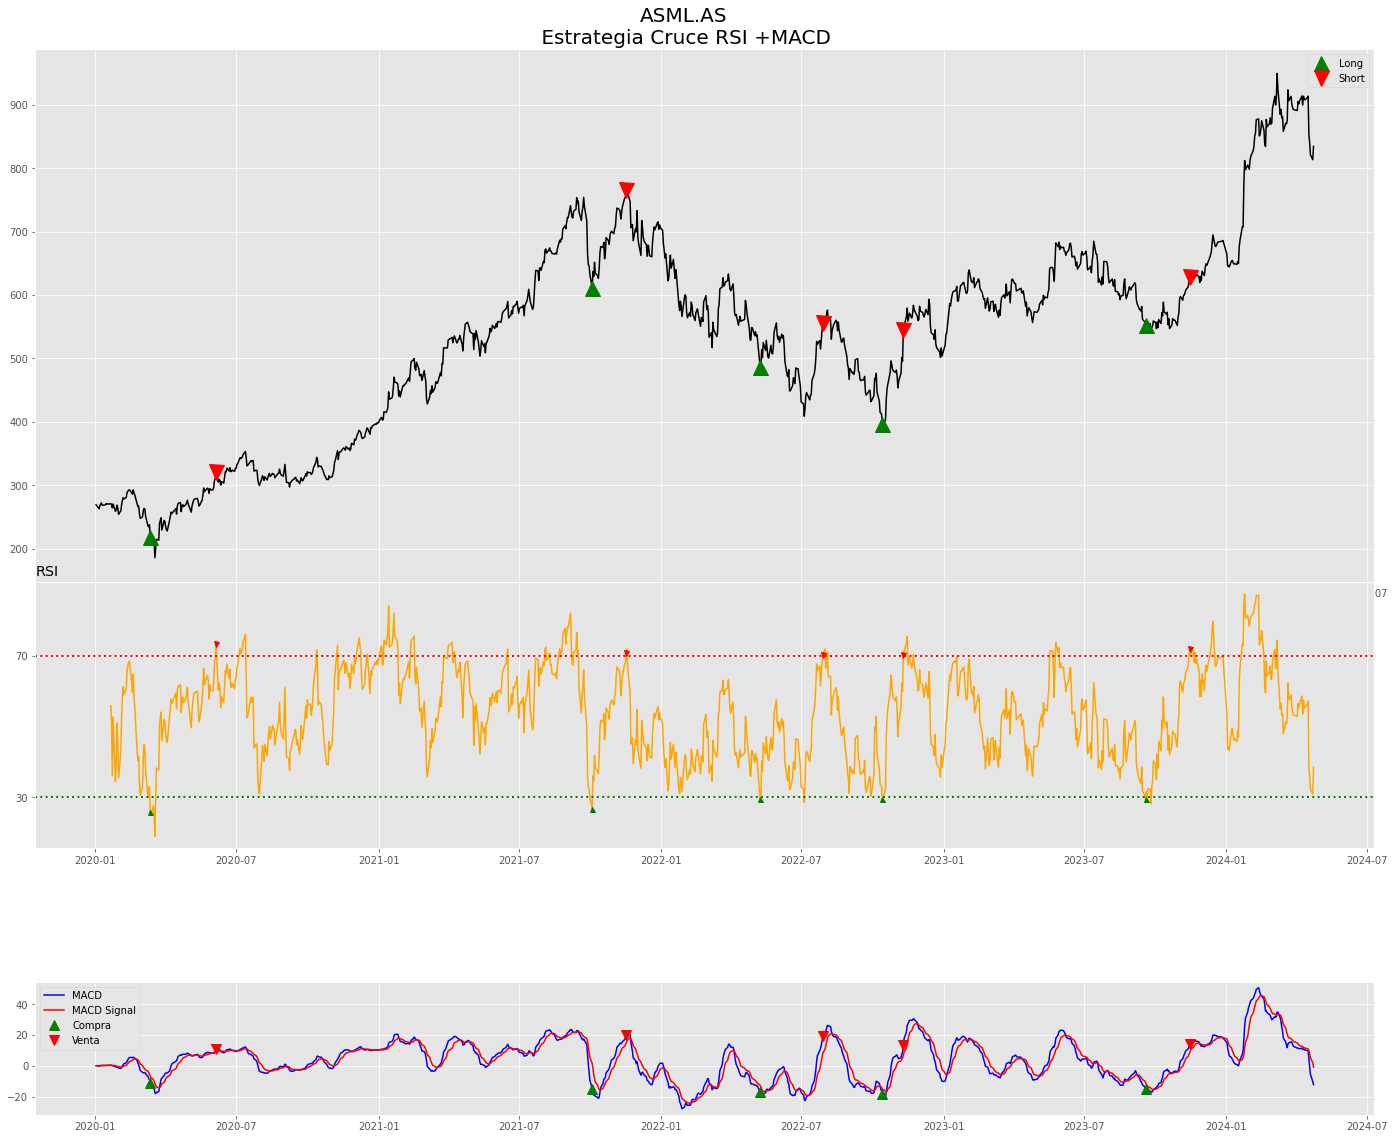

In [91]:
bkbase.Estrategia_RSI_MACD()